In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
import pretrainedmodels
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
np.random.seed(0)

# Data import

In [2]:
path = IMG_PATH/'pixel_squares_images'

In [3]:
train_df = pd.read_csv(IMG_PATH/'train.csv'); len(train_df); train_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,92,150,104,106,0,0,0,192,87,...,185,200,46,102,68,87,127,85,0,0.000068
1,1,143,87,161,77,0,0,0,181,88,...,0,0,0,67,99,139,79,0,1,0.000337
2,2,109,141,84,192,109,94,130,60,136,...,95,138,124,167,139,88,178,170,1,0.000027
3,3,136,131,162,127,0,0,0,130,143,...,144,143,98,131,151,65,91,85,1,0.000337
4,4,131,54,140,78,0,0,0,188,91,...,0,0,0,59,65,172,84,0,1,0.000337


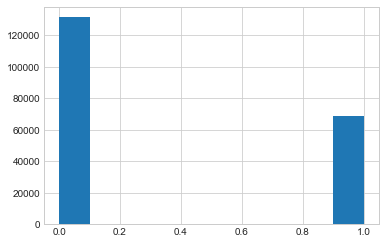

In [4]:
train_df.gen_target.hist()

In [5]:
len(train_df[train_df.gen_target==0])/len(train_df), len(train_df[train_df.gen_target==1])/len(train_df)

(0.65733, 0.34267)

In [6]:
size = 56

In [7]:
data = ImageDataBunch.from_df(df=train_df, label_col='gen_target', fn_col='image_name',
                              bs=200, ds_tfms=None, num_workers=8, valid_pct=0.2,
                              path=path, folder='train', suffix='.png').normalize(imagenet_stats)

In [8]:
data

ImageDataBunch;

Train: LabelList (160000 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
0,1,1,1,1
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Valid: LabelList (40000 items)
x: ImageList
Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56),Image (3, 56, 56)
y: CategoryList
1,1,1,1,0
Path: /home/giles/Documents/kaggle/higgsml/pixel_squares_images;

Test: None

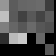

In [9]:
data.train_ds[0][0]

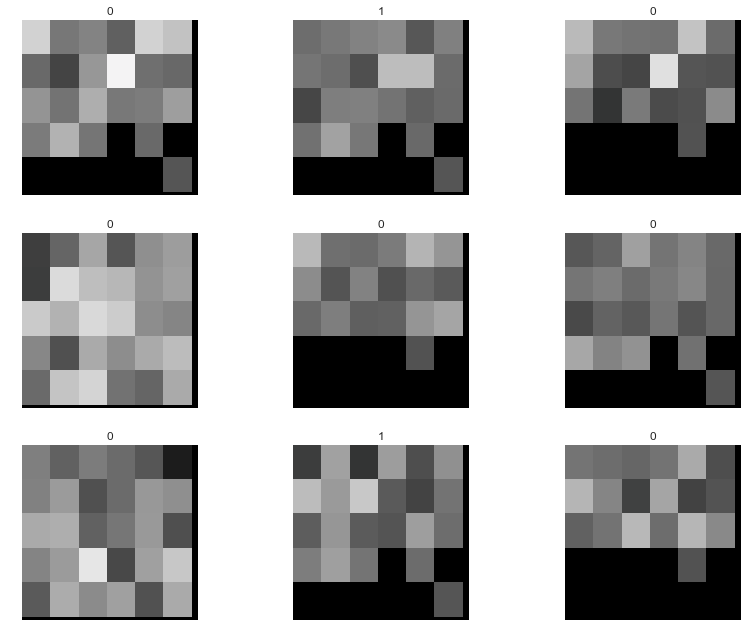

In [10]:
data.show_batch(rows=3, figsize=(12,9))

# Model training

In [9]:
def se_resnet154(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.senet154(pretrained=pretrained)
    return model

In [10]:
learn = cnn_learner(data, se_resnet154, pretrained=True, cut=-3, split_on=lambda m: (m[0][3], m[1]), metrics=error_rate)

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu3): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEBottleneck(
        (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runni

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


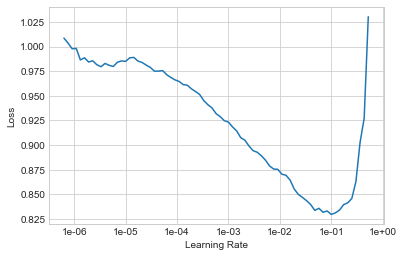

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=3e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.405938,0.413620,0.190450,07:26
1,0.386443,0.403913,0.173750,07:26
2,0.365567,0.363401,0.162500,07:27
3,0.353253,0.362502,0.157825,07:22


In [16]:
learn.save('stage-1')

In [11]:
learn.load('stage-1');

In [12]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


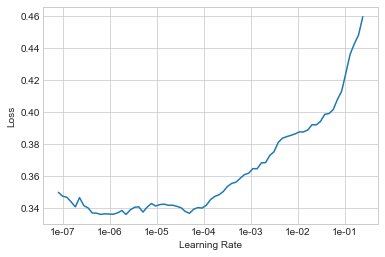

In [14]:
learn.lr_find(1e-8)
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(1e-8,1e-6))

epoch,train_loss,valid_loss,error_rate,time
0,0.343388,0.354032,0.157675,10:01
1,0.343878,0.354774,0.157975,10:03
2,0.344033,0.355835,0.157875,10:02
3,0.339105,0.369691,0.158025,09:59


In [16]:
learn.save('stage-2')

In [17]:
learn.load('stage-2');

In [18]:
learn.export()

## Interpretation

### Heatmap
Copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb

In [19]:
x,y = data.valid_ds[1]

In [20]:
m = learn.model.eval();

In [21]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [22]:
from fastai.callbacks.hooks import *

In [23]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [24]:
hook_a,hook_g = hooked_backward()

In [25]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([2048, 2, 2])

In [26]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([2, 2])

In [27]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,size,size,0),
              interpolation='bilinear', cmap='magma');

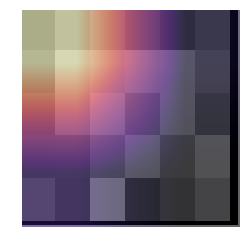

In [28]:
show_heatmap(avg_acts)

### Grad-CAM

In [29]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([2048, 2, 2]), torch.Size([2048]))

In [30]:
mult = (acts*grad_chan[...,None,None]).mean(0)

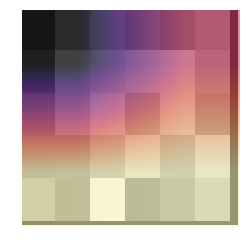

In [31]:
show_heatmap(mult)

# Inference

## Validation

In [32]:
val_df = pd.read_csv(IMG_PATH/'val.csv'); len(val_df); val_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight
0,0,161,177,121,91,0,0,0,190,131,...,0,0,0,111,60,180,96,0,0,2.420044
1,1,130,60,105,188,206,186,55,67,81,...,81,107,7,157,237,165,161,170,1,0.001503
2,2,126,203,96,108,0,0,0,145,180,...,0,0,0,112,92,107,156,0,0,4.668122
3,3,69,129,82,77,0,0,0,122,87,...,0,0,0,125,114,120,100,0,0,4.630882
4,4,89,102,105,77,0,0,0,157,88,...,0,0,0,91,93,170,80,0,0,4.245663


In [33]:
val_lst = ImageList.from_df(val_df, path, folder='val', suffix='.png')

In [34]:
learn = load_learner(path, test=val_lst)

In [35]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
val_df['pred'] = to_np(multiclass2binary(preds))

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


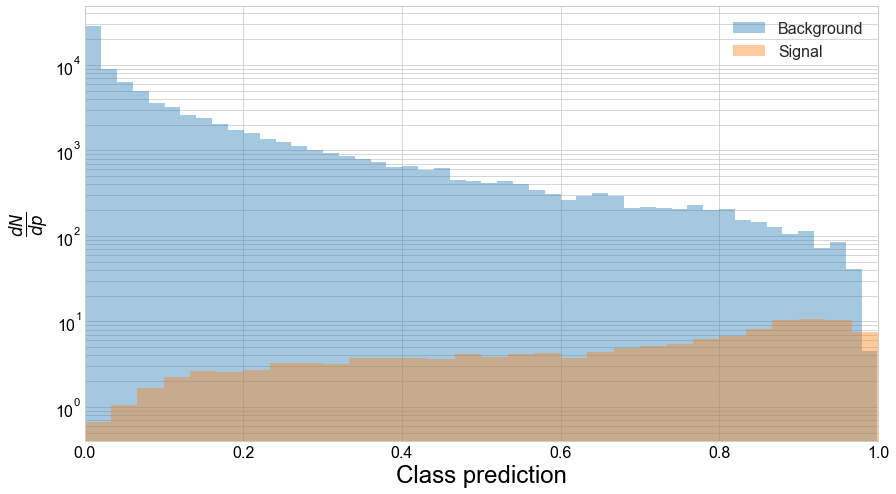

In [37]:
plot_binary_class_pred(val_df, wgt_name='gen_weight', density=False, log_y=True)

Mean cut at 0.8773534893989563 corresponds to AMS of 3.782914323790785
Maximum AMS for data is 3.88521506016191 at cut of 0.8350542783737183


/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


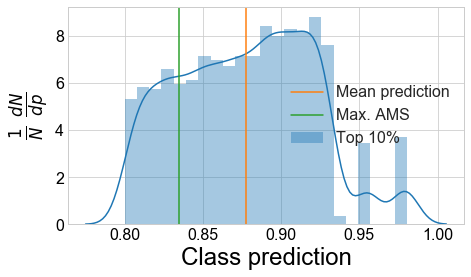

In [38]:
cut, smooth_ams, max_ams = binary_class_cut(val_df, top_perc=10, br=10, wgt_factor=250000/50000, min_pred=0.8)

## Test

In [39]:
test_df = pd.read_csv(IMG_PATH/'test.csv'); len(test_df); test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private
0,0,151,212,166,94,0,0,0,147,140,...,0,0,93,121,144,117,0,0,2.782544,1
1,1,87,161,96,93,143,100,107,175,91,...,133,131,109,73,129,111,170,0,0.171749,1
2,2,149,55,147,178,0,0,0,119,90,...,158,84,203,60,93,131,85,1,0.000840,1
3,3,99,114,93,200,0,0,0,57,104,...,27,98,176,237,233,157,85,0,0.932279,1
4,4,130,153,113,178,136,115,113,85,87,...,55,100,141,133,114,128,170,1,0.000840,1


In [40]:
test_lst = ImageList.from_df(test_df, path, folder='test', suffix='.png')

In [41]:
learn = load_learner(path, test=test_lst)

In [42]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [43]:
test_df['pred'] = to_np(multiclass2binary(preds))

In [44]:
test_df.head()

,image_name,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,private,pred
0,0,151,212,166,94,0,0,0,147,140,...,0,93,121,144,117,0,0,2.782544,1,0.109350
1,1,87,161,96,93,143,100,107,175,91,...,131,109,73,129,111,170,0,0.171749,1,0.127926
2,2,149,55,147,178,0,0,0,119,90,...,84,203,60,93,131,85,1,0.000840,1,0.963572
3,3,99,114,93,200,0,0,0,57,104,...,98,176,237,233,157,85,0,0.932279,1,0.247906
4,4,130,153,113,178,136,115,113,85,87,...,100,141,133,114,128,170,1,0.000840,1,0.959564


In [45]:
score_test_df(test_df, cut)

Public:Private AMS: 3.3791669910332423 : 3.515916514282943


(3.3791669910332423, 3.515916514282943)

In [51]:
score_test_df(test_df, 0.8350542783737183)

Public:Private AMS: 3.441433287472135 : 3.557950447566425


(3.441433287472135, 3.557950447566425)

In [46]:
from lumin.evaluation.ams import *
from sklearn.model_selection import StratifiedKFold, KFold

In [47]:
ams_scan_quick(test_df[test_df.private==0], br=10), ams_scan_quick(test_df[test_df.private==1], br=10)

((3.5241251048440017, 0.8094267249107361),
 (3.573276707764097, 0.8516372442245483))

In [48]:
def subsample_score_test(df:pd.DataFrame, cut:Optional[float]=None):
    amss = pd.DataFrame(columns=['Public_AMS', 'Private_AMS', 'Public_Cut', 'Private_Cut'])
    skf = StratifiedKFold(10, True)
    folds = skf.split(df, df.private)
    for _, fold in folds:
        test_fold = test_df.iloc[fold]
        if cut is None:
            public_ams, public_cut = ams_scan_quick(test_fold[test_fold.private==0], br=10, wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]))
            private_ams, private_cut = ams_scan_quick(test_fold[test_fold.private==1], br=10, wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        else:
            public_cut,private_cut = cut,cut 
            public_ams, private_ams = score_test_df(test_fold, cut, verbose=False,
                                                    public_wgt_factor=len(test_df[test_df.private==0])/len(test_fold[test_fold.private==0]),
                                                    private_wgt_factor=len(test_df[test_df.private==1])/len(test_fold[test_fold.private==1]))
        amss = amss.append({'Public_AMS':public_ams, 'Private_AMS':private_ams, 'Public_Cut':public_cut, 'Private_Cut':private_cut}, ignore_index=True)
    return amss

In [49]:
results = subsample_score_test(test_df); results

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
0,4.197603,3.863798,0.953425,0.838831
1,3.162867,3.518421,0.783610,0.832016
2,6.149890,3.701160,0.972726,0.866604
3,5.106546,3.687398,0.980019,0.845632
4,3.892142,3.680276,0.787279,0.849018
5,4.155620,4.056624,0.979705,0.966213
6,3.798083,3.771503,0.812907,0.879470
7,5.207221,3.577350,0.948146,0.840349
8,4.131862,3.714305,0.923979,0.863670
9,5.902263,3.769446,0.975602,0.967768


In [50]:
results.describe()

,Public_AMS,Private_AMS,Public_Cut,Private_Cut
count,10.000000,10.000000,10.000000,10.000000
mean,4.570410,3.734028,0.911740,0.874957
std,0.971976,0.149494,0.082978,0.050595
min,3.162867,3.518421,0.783610,0.832016
25%,3.952072,3.682057,0.840675,0.841670
50%,4.176611,3.707733,0.950786,0.856344
75%,5.182052,3.770989,0.974883,0.876253
max,6.149890,4.056624,0.980019,0.967768
